Create Embedding Network

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import matplotlib.pyplot as plt
#!pip install tensorflow==2.9.1 # For EfficientNetB0
import tensorflow as tf
import math

import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16, imagenet_utils
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import itertools

from skimage import exposure

import logging
from tensorflow.keras.models import load_model

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.12.0
	• tf.keras version: 2.12.0
	• Running on GPU


Load Dataset (Using 150x150)

In [5]:
""" load the datasets """

base_dir = os.path.join('dataset', 'pretrain4w')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_glioma_dir = os.path.join(train_dir, 'glioma_tumor')
train_meningioma_dir = os.path.join(train_dir, 'meningioma_tumor')
train_normal_dir = os.path.join(train_dir, 'no_tumor')
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')

val_glioma_dir = os.path.join(val_dir, 'glioma_tumor')
val_meningioma_dir = os.path.join(val_dir, 'meningioma_tumor')
val_normal_dir = os.path.join(val_dir, 'no_tumor')
val_pituitary_dir = os.path.join(val_dir, 'pituitary_tumor')

INPUT_SIZE = 150
BATCH_SIZE = 16

""" Investigate train - val datasets """

train_batches = ImageDataGenerator(rescale = 1 / 255.).flow_from_directory(train_dir,
                                                         target_size=(INPUT_SIZE,INPUT_SIZE),
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         seed=42,
                                                         batch_size=BATCH_SIZE)

val_batches = ImageDataGenerator(rescale = 1 / 255.).flow_from_directory(val_dir,
                                                         target_size=(INPUT_SIZE,INPUT_SIZE),
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         seed=42,
                                                         batch_size=BATCH_SIZE)

num_glioma_train = int(len(os.listdir(train_glioma_dir)))
num_meningioma_train = int(len(os.listdir(train_meningioma_dir)))
num_normal_train = int(len(os.listdir(train_normal_dir)))
num_pituitary_train = int(len(os.listdir(train_pituitary_dir)))

num_glioma_val = int(len(os.listdir(val_glioma_dir)))
num_meningioma_val = int(len(os.listdir(val_meningioma_dir)))
num_normal_val = int(len(os.listdir(val_normal_dir)))
num_pituitary_val = int(len(os.listdir(val_pituitary_dir)))

print('The dataset contains:')
print('\u2022 {} training images'.format(num_glioma_train + num_meningioma_train + num_normal_train + num_pituitary_train))
print('\u2022 {} validation images'.format(num_glioma_val + num_meningioma_val + num_normal_val + num_pituitary_val))

print('\nThe training set contains:')
print('\u2022 {} glioma images'.format(num_glioma_train))
print('\u2022 {} meningioma images'.format(num_meningioma_train))
print('\u2022 {} normal images'.format(num_normal_train))
print('\u2022 {} pituitary images'.format(num_pituitary_train))

print('\nThe validation set contains:')
print('\u2022 {} glioma images'.format(num_glioma_val))
print('\u2022 {} meningioma images'.format(num_meningioma_val))
print('\u2022 {} normal images'.format(num_normal_val))
print('\u2022 {} pituitary images'.format(num_pituitary_val))

Found 1372 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
The dataset contains:
• 1372 training images
• 40 validation images

The training set contains:
• 343 glioma images
• 343 meningioma images
• 343 normal images
• 343 pituitary images

The validation set contains:
• 10 glioma images
• 10 meningioma images
• 10 normal images
• 10 pituitary images


In [6]:
MODEL_FNAME = 'embedding_network.h5'

tf.compat.v1.reset_default_graph()

tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)


""" Create the model """
    
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9750 - Test: 0.94557
#base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0312 - accuracy: 0.9920 - val_loss: 0.1799 - val_accuracy: 0.9250 - Test: 0.933673
#base_model = Xception(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0335 - accuracy: 0.9978 - val_loss: 0.3005 - val_accuracy: 0.9000
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0912 - accuracy: 0.9730 - val_loss: 0.1897 - val_accuracy: 0.9250
#base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.2221 - val_accuracy: 0.9250
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0028 - accuracy: 0.9985 - val_loss: 0.1825 - val_accuracy: 0.9250
#base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3)) # loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.1836 - val_accuracy: 0.9750 - Test: 0.930272

print("Number of layers in the base model: ", len(base_model.layers))
    
base_model.trainable = True
    
base_model.summary()
    
last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dropout(rate=0.5)(x)

x = Flatten()(x)
x = Dense(4, activation='softmax')(x)
    
embedding_network = Model(inputs=[base_model.input], outputs=[x])
    
optimizer = Adam(learning_rate=0.00001) 
embedding_network.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
embedding_network.summary()
    
""" callbacks """
    
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
checkpointer = ModelCheckpoint(filepath='embedding_network.h5', verbose=1, 
                                   save_best_only=True)

58889256/58889256 [==============================] - 0s 0us/step
Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                      

Epoch 1/140
86/86 [==============================] - ETA: 0s - loss: 1.1561 - accuracy: 0.4796
Epoch 1: val_loss improved from inf to 0.76707, saving model to embedding_network.h5
86/86 [==============================] - 37s 180ms/step - loss: 1.1561 - accuracy: 0.4796 - val_loss: 0.7671 - val_accuracy: 0.7250
Epoch 2/140
86/86 [==============================] - ETA: 0s - loss: 0.7317 - accuracy: 0.7230
Epoch 2: val_loss improved from 0.76707 to 0.53831, saving model to embedding_network.h5
86/86 [==============================] - 10s 116ms/step - loss: 0.7317 - accuracy: 0.7230 - val_loss: 0.5383 - val_accuracy: 0.8000
Epoch 3/140
86/86 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.8025
Epoch 3: val_loss improved from 0.53831 to 0.50126, saving model to embedding_network.h5
86/86 [==============================] - 11s 126ms/step - loss: 0.5368 - accuracy: 0.8025 - val_loss: 0.5013 - val_accuracy: 0.8000
Epoch 4/140
86/86 [==============================] - ETA

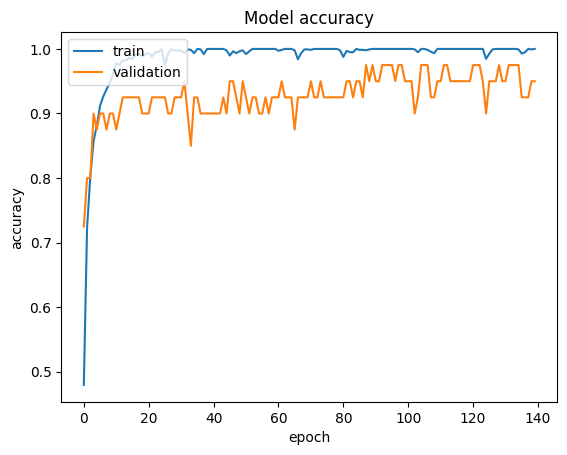

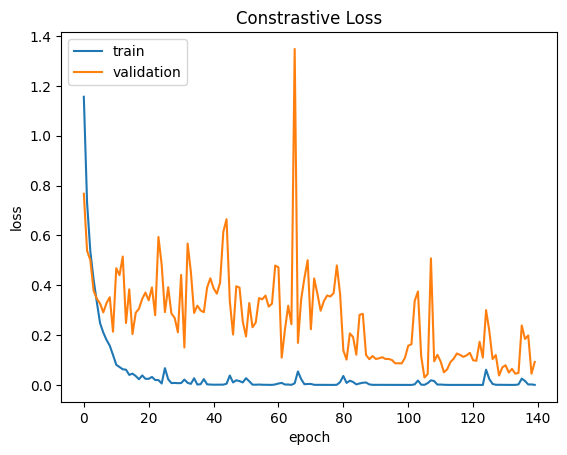

End of Training, the model is saved to embedding_network.h5


In [7]:
""" Train the model """
    
history = embedding_network.fit(
    train_batches,
    validation_data = val_batches,
    epochs = 140,
    verbose = 1,
    shuffle = True,
    callbacks = [checkpointer]#, early_stopping]
)
    
""" plot the train and val accuracies """
# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")
    
# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

    
print("End of Training, the model is saved to", MODEL_FNAME)  

Found 588 images belonging to 4 classes.

The test set contains:
• 147 glioma images
• 147 meningioma images
• 147 normal images
• 147 pituitary images
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 7

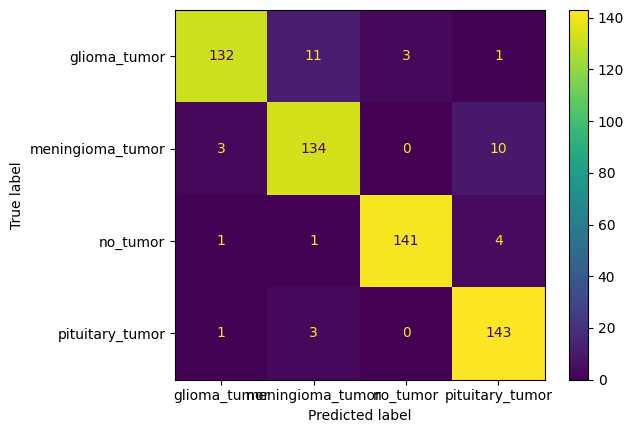

In [8]:
test_batches = ImageDataGenerator(rescale = 1 / 255.).flow_from_directory(test_dir,
                                                        target_size=(INPUT_SIZE,INPUT_SIZE),
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        seed=42,
                                                        batch_size=BATCH_SIZE)
    

test_glioma_dir = os.path.join(test_dir, 'glioma_tumor')
test_meningioma_dir = os.path.join(test_dir, 'meningioma_tumor')
test_normal_dir = os.path.join(test_dir, 'no_tumor')
test_pituitary_dir = os.path.join(test_dir, 'pituitary_tumor')
    
num_glioma_test = int(len(os.listdir(test_glioma_dir)))
num_meningioma_test = int(len(os.listdir(test_meningioma_dir)))
num_normal_test = int(len(os.listdir(test_normal_dir)))
num_pituitary_test = int(len(os.listdir(test_pituitary_dir)))

print('\nThe test set contains:')
print('\u2022 {} glioma images'.format(num_glioma_test))
print('\u2022 {} meningioma images'.format(num_meningioma_test))
print('\u2022 {} normal images'.format(num_normal_test))
print('\u2022 {} pituitary images'.format(num_pituitary_test))

""" Test the model """
model = tf.keras.models.load_model(MODEL_FNAME)
model.summary()
    
y_test = test_batches.classes
    
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_batches, (num_glioma_test + num_meningioma_test + num_normal_test + num_pituitary_test) // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
    
class_labels = list(test_batches.class_indices.keys())   
    
cm = confusion_matrix(test_batches.classes, y_pred)    
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot()
    
# results = model.evaluate_generator(test_batches)
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    
tf.keras.backend.clear_session()

Siamese Network

In [1]:
# -*- coding: utf-8 -*-
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')


Using:
	• TensorFlow version: 2.12.0
	• tf.keras version: 2.12.0
	• Running on GPU


In [2]:
INPUT_SIZE = 150

basedir = os.path.join("dataset", "siamese") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (INPUT_SIZE,INPUT_SIZE))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (INPUT_SIZE,INPUT_SIZE))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (INPUT_SIZE,INPUT_SIZE))   
print("The test set contains", len(test_image_list))  

# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

# utils.visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

tf.compat.v1.reset_default_graph()

Found 40 images belonging to 4 classes.
The train set contains 40
Found 40 images belonging to 4 classes.
The valid set contains 40
Found 1920 images belonging to 4 classes.
The test set contains 1920
number of pairs for training 80
number of pairs for validation 80
number of pairs for test 3840


In [3]:
SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

    
input_1 = Input((INPUT_SIZE,INPUT_SIZE,3))
input_2 = Input((INPUT_SIZE,INPUT_SIZE,3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_FNAME)
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
# merge_layer = Lambda(utils.euclidean_distance)([output_1, output_2]) 
merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath=SIAMESE_MODEL_FNAME, verbose=1, 
                                save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14742340    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14742340    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

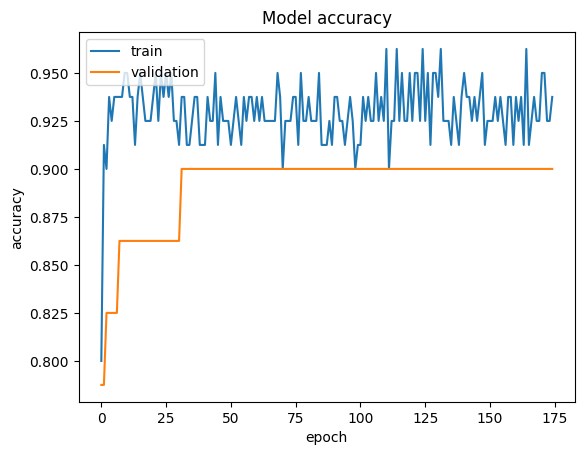

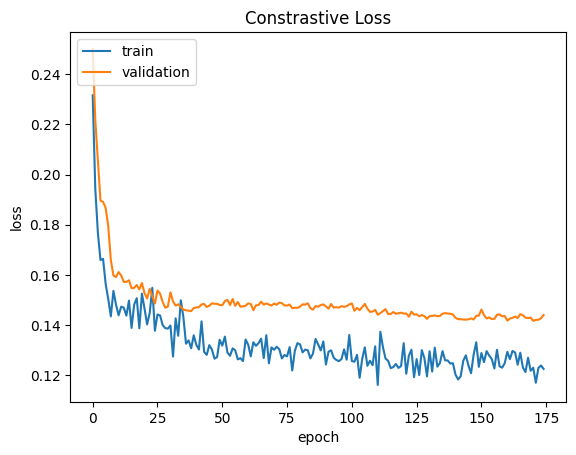

In [12]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"]) # Manhattan [loss: 0.0997 - accuracy: 0.9539] | Euclidean [loss: 0.2267 - accuracy: 0.9487]
# siamese.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"]) # Manhattan [loss: 0.4305 - accuracy: 0.9430] | Euclidean [loss: 0.6142 - accuracy: 0.9464]

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=175,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, reduce_lr]#, early_stopping]
)

# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")


120/120 [==============================] - 26s 123ms/step - loss: 0.1279 - accuracy: 0.9453
test loss, test acc: [0.12794193625450134, 0.9453125]
120/120 [==============================] - 15s 121ms/step

Evaluate on test data
Accuracy: 0.9453125
Precision: 0.9478315524827152
Recall: 0.9453125
ROC AUC: 0.9453124999999999
F1: 0.945235487404162
Specificity: 0.9828125


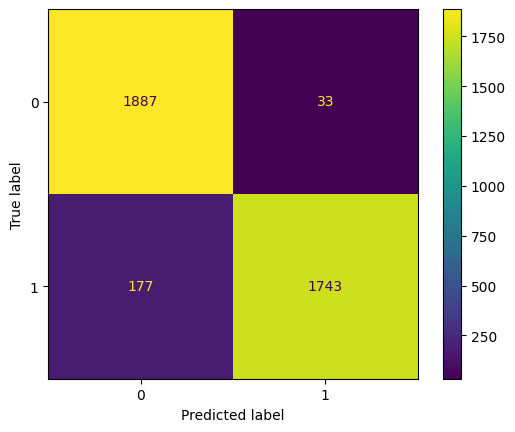

In [4]:
""" Test the model """
siamese = tf.keras.models.load_model(SIAMESE_MODEL_FNAME, custom_objects={'contrastive_loss': utils.loss(1)})

results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
y_pred = Y_pred > 0.5
y_test = labels_test

print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred)    
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

tf.keras.backend.clear_session()